<a href="https://colab.research.google.com/github/forneyd/MedicareReimbursement/blob/main/MedicareReimbursement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecasting Annual Medicare Fee-for-Service Reimbursements for Carrier Claims (2008-2010)

The term "annual carrier Medicare reimbursement" refers to the payments made by Medicare to healthcare providers or carriers for services rendered to Medicare beneficiaries. It encompasses reimbursements for a wide range of medical services, procedures, and treatments covered by Medicare Part B, which includes outpatient services like doctor's visits, preventive care, lab tests, medical equipment, and certain other outpatient treatments.

Carriers or providers submit claims to Medicare for the services they provide to eligible beneficiaries. Medicare then reimburses these carriers or healthcare providers based on predetermined fee schedules or other payment mechanisms established by Medicare.

## Importing the libraries

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [319]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 1000]


### Importing the dataset

In [320]:
df = pd.read_csv('DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv')
df = df.rename(columns={'DESYNPUF_ID': 'ID', 'BENE_BIRTH_DT':'Birth_Date', 'BENE_DEATH_DT':'Death_Date', 'BENE_SEX_IDENT_CD':'Sex',
                        'BENE_RACE_CD':'RACE', 'SP_STATE_CODE':'State_Code', 'BENE_ESRD_IND':'End_Renal',
                        'BENE_HI_CVRAGE_TOT_MONS':'Total_Months_PartA', 'BENE_SMI_CVRAGE_TOT_MONS':'Total_Months_PartB',
                       'BENE_HMO_CVRAGE_TOT_MONS':'Total_Months_HMO', 'PLAN_CVRG_MOS_NUM':'Total_Months_PartD'})


In [321]:
df.isnull().sum()

ID                         0
Birth_Date                 0
Death_Date            114538
Sex                        0
RACE                       0
End_Renal                  0
State_Code                 0
BENE_COUNTY_CD             0
Total_Months_PartA         0
Total_Months_PartB         0
Total_Months_HMO           0
Total_Months_PartD         0
SP_ALZHDMTA                0
SP_CHF                     0
SP_CHRNKIDN                0
SP_CNCR                    0
SP_COPD                    0
SP_DEPRESSN                0
SP_DIABETES                0
SP_ISCHMCHT                0
SP_OSTEOPRS                0
SP_RA_OA                   0
SP_STRKETIA                0
MEDREIMB_IP                0
BENRES_IP                  0
PPPYMT_IP                  0
MEDREIMB_OP                0
BENRES_OP                  0
PPPYMT_OP                  0
MEDREIMB_CAR               0
BENRES_CAR                 0
PPPYMT_CAR                 0
dtype: int64

In [322]:
df = df.dropna()
df = df.drop('BENE_COUNTY_CD', axis=1)

In [323]:
df['End_Renal'] = df['End_Renal'].replace(['Y', 1], ['0', 0])

In [324]:
df['End_Renal']

118       0
165       0
200       0
214       0
253       0
274       0
456       0
466       0
503       0
616       0
674       0
709       0
731       0
805       0
846       0
857       0
917       0
943       0
1197      0
1233      0
1238      0
1243      0
1324      0
1477      0
1602      0
1664      0
1800      0
1804      0
1847      0
1889      0
1892      0
1902      0
1994      0
2017      0
2169      0
2179      0
2235      0
2294      0
2317      0
2410      0
2491      0
2528      0
2565      0
2662      0
2675      0
2703      0
2718      0
2736      0
2756      0
2817      0
3010      0
3116      0
3148      0
3229      0
3258      0
3440      0
3537      0
3649      0
3664      0
3673      0
3819      0
3825      0
4073      0
4132      0
4306      0
4387      0
4441      0
4566      0
4570      0
4631      0
4650      0
4652      0
4678      0
4731      0
4885      0
5064      0
5091      0
5100      0
5210      0
5232      0
5442      0
5551      0
5638      0
5714

In [325]:
MEDREIMB_CAR = df.pop('MEDREIMB_CAR')
df['MEDREIMB_CAR'] = MEDREIMB_CAR

In [326]:
# Check unique values in the binary variables to understand their current representation
print(df['SP_ALZHDMTA'].unique())
print(df['SP_CHF'].unique())
print(df['SP_CHRNKIDN'].unique())
print(df['SP_CNCR'].unique())
print(df['SP_COPD'].unique())
print(df['SP_DEPRESSN'].unique())
print(df['SP_DIABETES'].unique())
print(df['SP_ISCHMCHT'].unique())
print(df['SP_OSTEOPRS'].unique())
print(df['SP_RA_OA'].unique())
print(df['SP_STRKETIA'].unique())


[2 1]
[2 1]
[2 1]
[2 1]
[2 1]
[2 1]
[1 2]
[2 1]
[2 1]
[2 1]
[2 1]


In [327]:
# Recode binary variables to 0 and 1 if they are not already encoded that way
df['Sex'] = df['Sex'].map({2 : 0, 1: 1})
df['SP_ALZHDMTA'] = df['SP_ALZHDMTA'].map({2 : 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_CHF'] = df['SP_CHF'].map({2 : 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_CHRNKIDN'] = df['SP_CHRNKIDN'].map({2 : 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_CNCR'] = df['SP_CNCR'].map({2 : 0, 1 : 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_COPD'] = df['SP_COPD'].map({2 : 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_DEPRESSN'] = df['SP_DEPRESSN'].map({2 : 0, 1 : 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_DIABETES'] = df['SP_DIABETES'].map({2: 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_ISCHMCHT'] = df['SP_ISCHMCHT'].map({2 : 0, 1: 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_OSTEOPRS'] = df['SP_OSTEOPRS'].map({2 : 0, 1 : 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_RA_OA'] = df['SP_RA_OA'].map({2 : 0, 1 : 1})  # Replace 'No' with 0 and 'Yes' with 1
df['SP_STRKETIA'] = df['SP_STRKETIA'].map({2 : 0, 1 : 1})  # Replace 'No' with 0 and 'Yes' with 1

In [328]:
print(df['SP_ALZHDMTA'].unique())
print(df['SP_CHF'].unique())
print(df['SP_CHRNKIDN'].unique())
print(df['SP_CNCR'].unique())
print(df['SP_COPD'].unique())
print(df['SP_DEPRESSN'].unique())
print(df['SP_DIABETES'].unique())
print(df['SP_ISCHMCHT'].unique())
print(df['SP_OSTEOPRS'].unique())
print(df['SP_RA_OA'].unique())
print(df['SP_STRKETIA'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]


In [329]:
print(df)

                      ID  Birth_Date  Death_Date  Sex  RACE End_Renal  State_Code  Total_Months_PartA  Total_Months_PartB  Total_Months_HMO  Total_Months_PartD  SP_ALZHDMTA  SP_CHF  SP_CHRNKIDN  SP_CNCR  SP_COPD  SP_DEPRESSN  SP_DIABETES  SP_ISCHMCHT  SP_OSTEOPRS  SP_RA_OA  SP_STRKETIA  MEDREIMB_IP  BENRES_IP  PPPYMT_IP  MEDREIMB_OP  BENRES_OP  PPPYMT_OP  BENRES_CAR  PPPYMT_CAR  MEDREIMB_CAR
118     0033C90574583C0D    19360801  20080901.0    0     1         0          49                  12                  12                 0                  12            0       0            0        0        0            0            1            0            0         0            0          0.0        0.0        0.0          0.0        0.0        0.0       290.0         0.0         860.0
165     00521D781532612C    19370801  20080701.0    0     1         0          51                  12                  12                12                  12            1       0            0        0        

In [330]:
patientcounts = len(df)
print(patientcounts)

1814


In [331]:
Sexcounts = df['Sex'].value_counts()
print(Sexcounts)

0    1003
1     811
Name: Sex, dtype: int64


Male = 0
Female = 1

In [332]:
race_counts = df['RACE'].value_counts()
print(race_counts)

1    1527
2     189
3      64
5      34
Name: RACE, dtype: int64


1 White
2 Black
3 Others
5 Hispanic

In [333]:
alz_counts = df['SP_ALZHDMTA'].value_counts()
print(alz_counts)

0    1450
1     364
Name: SP_ALZHDMTA, dtype: int64


In [334]:
chf_counts = df['SP_CHF'].value_counts()
print(chf_counts)

0    1311
1     503
Name: SP_CHF, dtype: int64


In [335]:
cncr_counts = df['SP_CNCR'].value_counts()
print(cncr_counts)

0    1694
1     120
Name: SP_CNCR, dtype: int64


In [336]:
copd_counts = df['SP_COPD'].value_counts()
print(copd_counts)

0    1568
1     246
Name: SP_COPD, dtype: int64


In [337]:
dep_counts = df['SP_DEPRESSN'].value_counts()
print(dep_counts)

0    1407
1     407
Name: SP_DEPRESSN, dtype: int64


In [338]:
diab_counts = df['SP_DIABETES'].value_counts()
print(diab_counts)

0    1137
1     677
Name: SP_DIABETES, dtype: int64


In [339]:
X = df.iloc[:, 3:-1].values
y = df.iloc[:, -1:].values

In [340]:
print(X)

[[0 1 '0' 49 12 12 0 12 0 0 0 0 0 0 1 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  290.0 0.0]
 [0 1 '0' 51 12 12 12 12 1 0 0 0 0 1 1 1 0 1 0 0.0 0.0 0.0 530.0 110.0
  0.0 60.0 0.0]
 [1 3 '0' 33 12 12 0 0 0 1 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [0 2 '0' 5 12 12 0 12 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [1 1 '0' 33 12 12 0 12 0 1 0 0 0 0 1 0 1 1 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [0 1 '0' 11 12 12 0 0 0 1 0 0 0 1 1 1 1 1 0 0.0 0.0 0.0 0.0 0.0 0.0 10.0
  0.0]
 [1 1 '0' 15 12 12 0 12 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [1 1 '0' 5 12 12 12 12 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [0 2 '0' 19 12 12 0 12 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0]
 [0 1 '0' 16 12 12 0 12 0 1 0 0 0 1 1 1 1 1 0 0.0 0.0 0.0 1360.0 160.0
  0.0 90.0 0.0]
 [0 1 '0' 25 12 12 12 12 0 1 0 0 1 0 1 1 1 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0]
 [1 1 '0' 36 12 12 12 12 0 1 0 0 0 0 1 1 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0]
 [0 1 '0' 10 1

In [341]:
#One Hot Encoding categorical data
#Encoding the Independent Variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(),[1, 3])], remainder='passthrough')
X = ct.fit_transform(X)

In [342]:
np.set_printoptions(threshold=sys.maxsize)
print(X)

[[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
  0.0 0.0 0 '0' 12 12 0 12 0 0 0 0 0 0 1 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  290.0 0.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0
  0.0 0.0 0 '0' 12 12 12 12 1 0 0 0 0 1 1 1 0 1 0 0.0 0.0 0.0 530.0 110.0
  0.0 60.0 0.0]
 [0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1 '0' 12 12 0 0 0 1 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0]
 [0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 

In [343]:
print(y)

[[ 860.]
 [ 470.]
 [   0.]
 [   0.]
 [   0.]
 [  50.]
 [   0.]
 [   0.]
 [   0.]
 [ 560.]
 [   0.]
 [   0.]
 [ 290.]
 [   0.]
 [2420.]
 [   0.]
 [ 510.]
 [   0.]
 [2970.]
 [   0.]
 [2520.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [ 390.]
 [1060.]
 [ 150.]
 [1440.]
 [   0.]
 [   0.]
 [   0.]
 [1120.]
 [   0.]
 [4260.]
 [4700.]
 [   0.]
 [2300.]
 [   0.]
 [  30.]
 [   0.]
 [ 480.]
 [ 160.]
 [   0.]
 [   0.]
 [1240.]
 [1630.]
 [1020.]
 [1440.]
 [ 410.]
 [  10.]
 [  50.]
 [1600.]
 [   0.]
 [ 560.]
 [1080.]
 [1390.]
 [1740.]
 [1260.]
 [   0.]
 [ 200.]
 [   0.]
 [1290.]
 [   0.]
 [   0.]
 [   0.]
 [ 190.]
 [ 230.]
 [1000.]
 [   0.]
 [   0.]
 [  30.]
 [   0.]
 [ 200.]
 [ 510.]
 [ 120.]
 [1020.]
 [  60.]
 [ 490.]
 [2500.]
 [ 740.]
 [1670.]
 [1550.]
 [1070.]
 [   0.]
 [ 150.]
 [2530.]
 [ 550.]
 [  90.]
 [   0.]
 [ 460.]
 [   0.]
 [ 200.]
 [1310.]
 [1000.]
 [ 220.]
 [   0.]
 [1210.]
 [ 210.]
 [   0.]
 [2400.]
 [   0.]
 [ 470.]
 [   0.]
 [  30.]
 [   0.]
 [   0.]
 [2360.]
 [   0.]
 [   0.]
 [  50.]
 

## Splitting the dataset into the Training set and Test set

In [344]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [345]:
print(X_test)

[[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0 '0' 12 12 0 0 0 1 1 0 1 0 1 1 0 1 0 22000.0 1024.0 0.0 0.0
  0.0 0.0 360.0 60.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
  0.0 0.0 1 '0' 12 12 9 12 1 1 1 0 1 0 1 1 0 1 1 31000.0 3072.0 0.0
  2030.0 670.0 0.0 970.0 30.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1 '0' 12 12 12 12 0 0 0 0 0 0 1 0 0 0 0 4000.0 1024.0 0.0 790.0
  200.0 0.0 280.0 0.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [346]:
print(X_train)

[[0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0 '0' 12 12 12 5 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 1840.0 220.0
  0.0 0.0 0.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 1 '0' 12 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0 0.0 0.0 0.0 0.0 0.0
  200.0 0.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0 '0' 12 12 0 0 1 0 0 0 0 0 1 1 0 0 1 0.0 0.0 0.0 50.0 90.0 0.0
  160.0 0.0]
 [1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [347]:
print(y_test)

[[1270.]
 [3730.]
 [1180.]
 [ 620.]
 [   0.]
 [1000.]
 [   0.]
 [ 790.]
 [ 630.]
 [ 410.]
 [   0.]
 [   0.]
 [   0.]
 [ 500.]
 [ 100.]
 [   0.]
 [ 940.]
 [ 190.]
 [   0.]
 [1890.]
 [ 140.]
 [  10.]
 [   0.]
 [ 150.]
 [ 350.]
 [1220.]
 [ 190.]
 [2370.]
 [   0.]
 [ 160.]
 [   0.]
 [2610.]
 [  80.]
 [1050.]
 [   0.]
 [2360.]
 [ 310.]
 [2970.]
 [   0.]
 [ 180.]
 [ 590.]
 [   0.]
 [ 380.]
 [ 240.]
 [1050.]
 [ 700.]
 [  30.]
 [   0.]
 [  40.]
 [   0.]
 [ 150.]
 [   0.]
 [   0.]
 [1300.]
 [ 890.]
 [ 800.]
 [   0.]
 [ 360.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [ 970.]
 [1370.]
 [ 690.]
 [   0.]
 [   0.]
 [ 130.]
 [1150.]
 [   0.]
 [3500.]
 [   0.]
 [1280.]
 [ 530.]
 [ 110.]
 [   0.]
 [ 740.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [ 210.]
 [1370.]
 [   0.]
 [  60.]
 [1710.]
 [   0.]
 [   0.]
 [4260.]
 [   0.]
 [ 250.]
 [   0.]
 [ 140.]
 [ 500.]
 [ 110.]
 [1870.]
 [ 160.]
 [ 120.]
 [   0.]
 [   0.]
 [   0.]
 [1020.]
 [ 190.]
 [1400.]
 [   0.]
 [   0.]
 [   0.]
 [ 130.]
 [ 150.]
 [ 100.]
 

## Training the Multiple Linear Regression model on the Training set

In [348]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

### Predicting the Test set results

In [349]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 1.24e+03  1.27e+03]
 [ 3.60e+03  3.73e+03]
 [ 1.07e+03  1.18e+03]
 [ 7.42e+02  6.20e+02]
 [-8.59e+01  0.00e+00]
 [ 1.04e+03  1.00e+03]
 [ 4.29e+01  0.00e+00]
 [ 9.59e+02  7.90e+02]
 [ 4.33e+02  6.30e+02]
 [ 5.18e+02  4.10e+02]
 [ 4.44e+01  0.00e+00]
 [ 3.26e+01  0.00e+00]
 [-5.36e+01  0.00e+00]
 [ 1.60e+02  5.00e+02]
 [ 1.16e+02  1.00e+02]
 [ 4.32e+01  0.00e+00]
 [ 1.27e+03  9.40e+02]
 [ 6.02e+01  1.90e+02]
 [-7.54e+00  0.00e+00]
 [ 1.58e+03  1.89e+03]
 [ 1.19e+02  1.40e+02]
 [ 9.30e+01  1.00e+01]
 [ 9.37e+01  0.00e+00]
 [ 9.37e+01  1.50e+02]
 [ 2.41e+02  3.50e+02]
 [ 8.08e+02  1.22e+03]
 [ 2.19e+02  1.90e+02]
 [ 3.19e+03  2.37e+03]
 [ 3.37e+01  0.00e+00]
 [ 2.10e+02  1.60e+02]
 [ 3.52e+01  0.00e+00]
 [ 3.13e+03  2.61e+03]
 [ 1.68e+02  8.00e+01]
 [ 4.70e+02  1.05e+03]
 [-3.39e+00  0.00e+00]
 [ 1.57e+03  2.36e+03]
 [ 1.82e+02  3.10e+02]
 [ 2.93e+03  2.97e+03]
 [ 1.39e+00  0.00e+00]
 [ 3.19e+02  1.80e+02]
 [ 6.45e+02  5.90e+02]
 [-3.50e+00  0.00e+00]
 [ 3.72e+02  3.80e+02]
 [ 2.43e+01

### Evaluating the Model Performance

In [350]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9171089161695379

### Prediction Example

In [351]:
X_new = [[0.0, 0.0, 1.0 ,0.0 ,0.0, 0.0, 0.0 ,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
  0.0, 0.0, 0, 0, 9, 9, 3, 9, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2000.0, 150.0, 0.0, 800.0,
  0.0, 0.0, 500.0, 0]]

In [352]:
new_prediction = regressor.predict(X_new)
print(new_prediction)

[[1628.87]]


**Results**

The predicted annual carrier Medicare reimbursement amount for a black woman in Michigan, living with COPD, Diabetes, Rheumatoid Arthritis, and depression, is estimated to be $1628.87. This prediction was generated using a multiple linear regression model based on various factors such as her medical conditions and previous Medicare reimbursements.

The breakdown of her Medicare reimbursements and responsibilities includes:

Inpatient annual Medicare reimbursement amount: $2000

Inpatient annual beneficiary responsibility amount: $150

No Inpatient annual primary payer reimbursement amount

Outpatient annual Medicare reimbursement amount: $800

No Outpatient annual beneficiary responsibility amount

No Outpatient annual primary payer reimbursement amount

Carrier annual beneficiary responsibility amount: $500

No Carrier annual primary payer reimbursement amount

The model took into account these reimbursements and responsibilities, along with the specific medical conditions she faces, to arrive at the estimated Carrier annual Medicare reimbursement amount.

This predictive model offers insights into potential Medicare reimbursements for a black woman in Michigan dealing with multiple chronic conditions, aiding in financial planning and resource allocation for her healthcare needs.

**Significance**

The annual Carrier Medicare reimbursement, especially in the context of predicting a specific amount ($1628.87 in this case), holds considerable significance for the healthcare planning and financial management of a black woman residing in Michigan with COPD, Diabetes, Rheumatoid Arthritis, and depression.

Understanding and predicting the Carrier Medicare reimbursement amount is crucial as it assists in projecting the expected financial support that the individual can anticipate receiving for their medical treatments and services. In this scenario, the predicted reimbursement amount of $1628.87, derived from a multiple linear regression model, serves as a valuable estimation tool. It factors in the individual's demographic data, medical conditions, and previous Medicare reimbursements to provide an approximation of the expected reimbursement.

This predicted reimbursement amount aids the individual and healthcare providers in several ways:

Financial Planning: It helps the individual in planning their healthcare expenses and budgeting for out-of-pocket costs, considering the estimated Medicare reimbursement for the upcoming year.

Resource Allocation: Healthcare providers and institutions can use this information to allocate resources and services effectively, ensuring adequate support and care for the patient's specific medical needs.

Treatment Decision-making: The predicted reimbursement amount can influence treatment decisions, ensuring that the individual can afford necessary treatments and services covered by Medicare.

Policy and Research Implications: Predictive models for Medicare reimbursement amounts, especially considering various medical conditions and demographics, contribute to policy discussions and further research on healthcare disparities and access to care for specific demographic groups facing multiple health challenges.

In summary, the estimated Carrier Medicare reimbursement amount of $1628.87, tailored to the individual's circumstances, plays a significant role in financial planning, resource allocation, and treatment decisions, facilitating better healthcare management for the black woman in Michigan with multiple chronic conditions.

### Visualising the Test set results

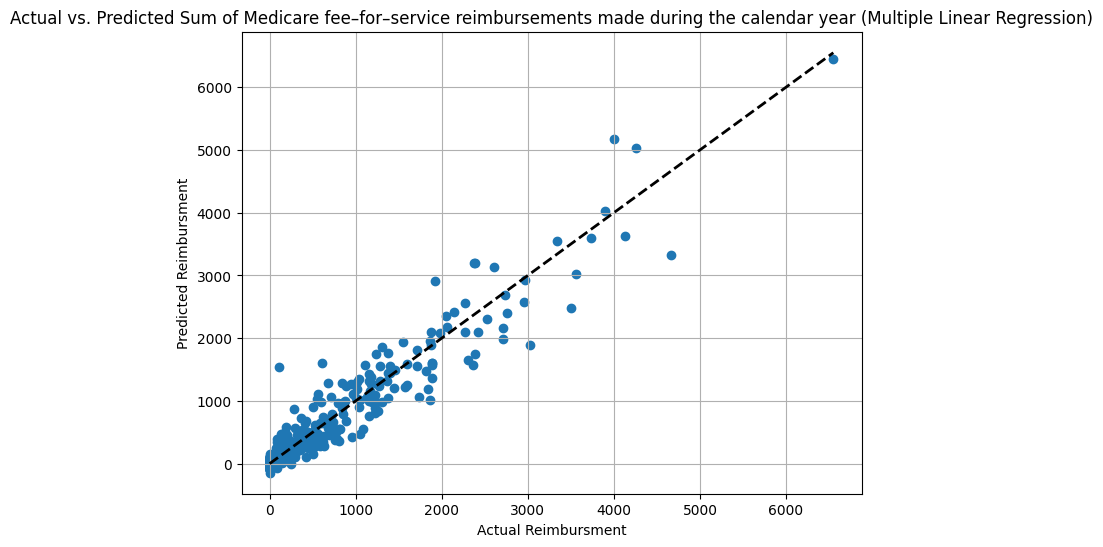

In [353]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Reimbursment')
plt.ylabel('Predicted Reimbursment')
plt.title('Actual vs. Predicted Sum of Medicare fee–for–service reimbursements made during the calendar year (Multiple Linear Regression)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

#### This plot compares the actual reimbursements (x-axis) to the predicted reimbursements (y-axis) for the Medicare fee-for-service claims. Ideally, the points should align along a diagonal line (y=x), indicating that predicted values closely match the actual values. If the points mostly cluster around the line, it suggests that the model is making accurate predictions. Dispersed or spread-out points away from the line may indicate discrepancies between actual and predicted values.

## Training the Random Forest Regression model on the whole dataset

In [354]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFregressor.fit(X_train, y_train)

<ipython-input-354-af5cccb35651>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFregressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

### Predicting the Test set results

In [355]:
y_pred_rf = RFregressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_rf.reshape(len(y_pred_rf),1), y_test.reshape(len(y_test),1)),1))

[[1.44e+03 1.27e+03]
 [3.74e+03 3.73e+03]
 [8.62e+02 1.18e+03]
 [8.56e+02 6.20e+02]
 [0.00e+00 0.00e+00]
 [9.24e+02 1.00e+03]
 [0.00e+00 0.00e+00]
 [1.24e+03 7.90e+02]
 [2.61e+02 6.30e+02]
 [4.15e+02 4.10e+02]
 [0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00]
 [2.03e+02 5.00e+02]
 [9.10e+01 1.00e+02]
 [0.00e+00 0.00e+00]
 [1.30e+03 9.40e+02]
 [1.23e+02 1.90e+02]
 [0.00e+00 0.00e+00]
 [1.70e+03 1.89e+03]
 [1.42e+02 1.40e+02]
 [1.00e+01 1.00e+01]
 [4.86e+00 0.00e+00]
 [1.17e+02 1.50e+02]
 [4.56e+02 3.50e+02]
 [7.88e+02 1.22e+03]
 [1.28e+02 1.90e+02]
 [3.00e+03 2.37e+03]
 [0.00e+00 0.00e+00]
 [2.48e+02 1.60e+02]
 [0.00e+00 0.00e+00]
 [3.52e+03 2.61e+03]
 [1.20e+02 8.00e+01]
 [4.55e+02 1.05e+03]
 [0.00e+00 0.00e+00]
 [1.34e+03 2.36e+03]
 [3.15e+02 3.10e+02]
 [2.90e+03 2.97e+03]
 [0.00e+00 0.00e+00]
 [3.42e+02 1.80e+02]
 [4.80e+02 5.90e+02]
 [0.00e+00 0.00e+00]
 [2.85e+02 3.80e+02]
 [1.32e+02 2.40e+02]
 [9.71e+02 1.05e+03]
 [8.82e+02 7.00e+02]
 [1.20e+01 3.00e+01]
 [0.00e+00 0.

### Evaluating the Model Performance

In [356]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_rf)

0.9024199038047211

### Prediction Example

In [357]:
new_rf_pred = RFregressor.predict(X_new)
print(new_rf_pred)

[1422.]


### Visualize Random Forest Model

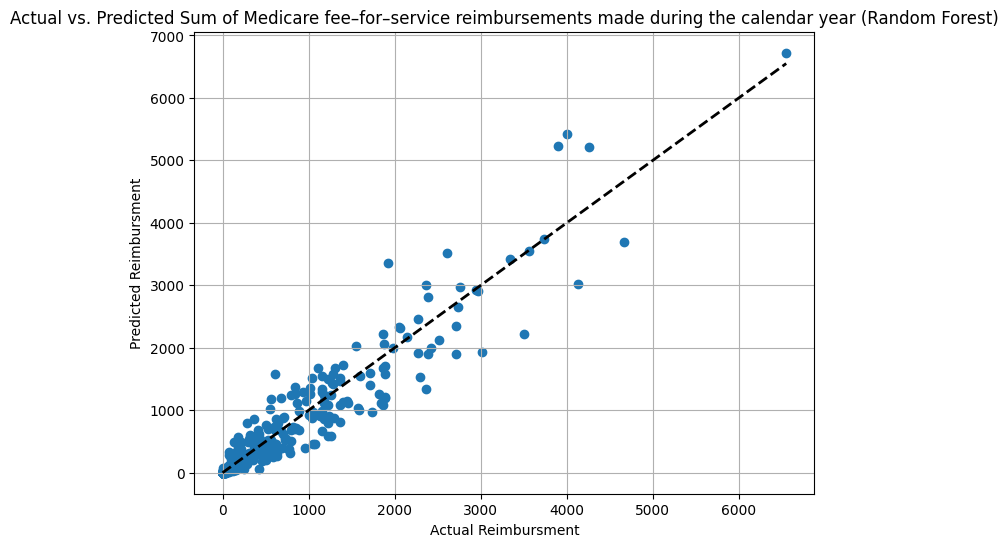

In [358]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Reimbursment')
plt.ylabel('Predicted Reimbursment')
plt.title('Actual vs. Predicted Sum of Medicare fee–for–service reimbursements made during the calendar year (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

## Training the XG Boost model on the whole dataset

In [359]:
import xgboost as xgb
xmodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100) # Adjust hyperparameters as needed
xmodel.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

### Predicting the Test set results

In [360]:
y_pred_x = xmodel.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_x.reshape(len(y_pred_x),1), y_test.reshape(len(y_test),1)),1))

[[ 2.08e+03  1.27e+03]
 [ 3.49e+03  3.73e+03]
 [ 9.00e+02  1.18e+03]
 [ 5.31e+02  6.20e+02]
 [-6.76e+00  0.00e+00]
 [ 8.68e+02  1.00e+03]
 [-2.76e+01  0.00e+00]
 [ 1.18e+03  7.90e+02]
 [ 4.02e+02  6.30e+02]
 [ 3.66e+02  4.10e+02]
 [ 3.42e+01  0.00e+00]
 [ 5.41e+00  0.00e+00]
 [ 9.10e-01  0.00e+00]
 [ 1.66e+02  5.00e+02]
 [ 3.46e+02  1.00e+02]
 [ 5.11e-01  0.00e+00]
 [ 1.22e+03  9.40e+02]
 [ 1.19e+02  1.90e+02]
 [ 1.26e+01  0.00e+00]
 [ 1.75e+03  1.89e+03]
 [ 1.41e+02  1.40e+02]
 [ 2.56e+02  1.00e+01]
 [ 1.81e-01  0.00e+00]
 [ 1.12e+02  1.50e+02]
 [ 2.74e+02  3.50e+02]
 [ 6.32e+02  1.22e+03]
 [ 1.28e+02  1.90e+02]
 [ 3.23e+03  2.37e+03]
 [ 3.06e+00  0.00e+00]
 [ 1.62e+02  1.60e+02]
 [ 3.95e+00  0.00e+00]
 [ 3.26e+03  2.61e+03]
 [ 6.60e+01  8.00e+01]
 [ 6.27e+02  1.05e+03]
 [ 1.80e+01  0.00e+00]
 [ 1.56e+03  2.36e+03]
 [ 4.91e+02  3.10e+02]
 [ 2.75e+03  2.97e+03]
 [ 2.27e+01  0.00e+00]
 [ 4.36e+02  1.80e+02]
 [ 7.19e+02  5.90e+02]
 [ 7.43e+01  0.00e+00]
 [ 2.76e+02  3.80e+02]
 [ 1.73e+02

### Evaulate the XG Boost Model

In [361]:
r2_score(y_test, y_pred_x)

0.8903923938014114

### Prediction Example

In [362]:
new_x_pred = xmodel.predict(X_new)
print(new_x_pred)

[1145.72]


### Visualize XG Boost Model

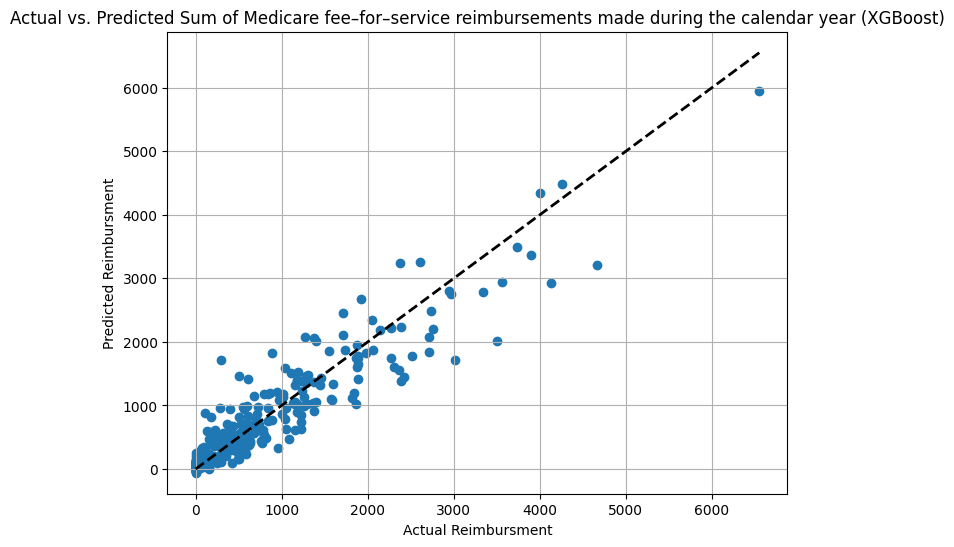

In [363]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_x)
plt.xlabel('Actual Reimbursment')
plt.ylabel('Predicted Reimbursment')
plt.title('Actual vs. Predicted Sum of Medicare fee–for–service reimbursements made during the calendar year (XGBoost)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()